# CSE455 / CSE552 – Homework #5  
**Student:** Selim Aynigül – 200104004004  

This notebook follows the required template:

* **Part I:** Code → Results → Conclusions  
* **Part II:** Code → Results → Conclusions  
* **Part III:** Code → Results → Conclusions  

In [1]:

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, warnings, random, inspect
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix,
                             ConfusionMatrixDisplay, classification_report)
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
from sklearn.base import BaseEstimator, ClassifierMixin
from IPython.display import display
warnings.filterwarnings('ignore')
np.random.seed(42); random.seed(42)


## Part I – Dataset
### Code

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64

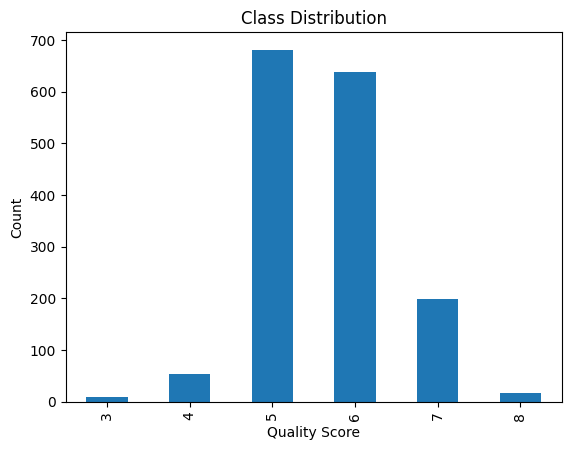

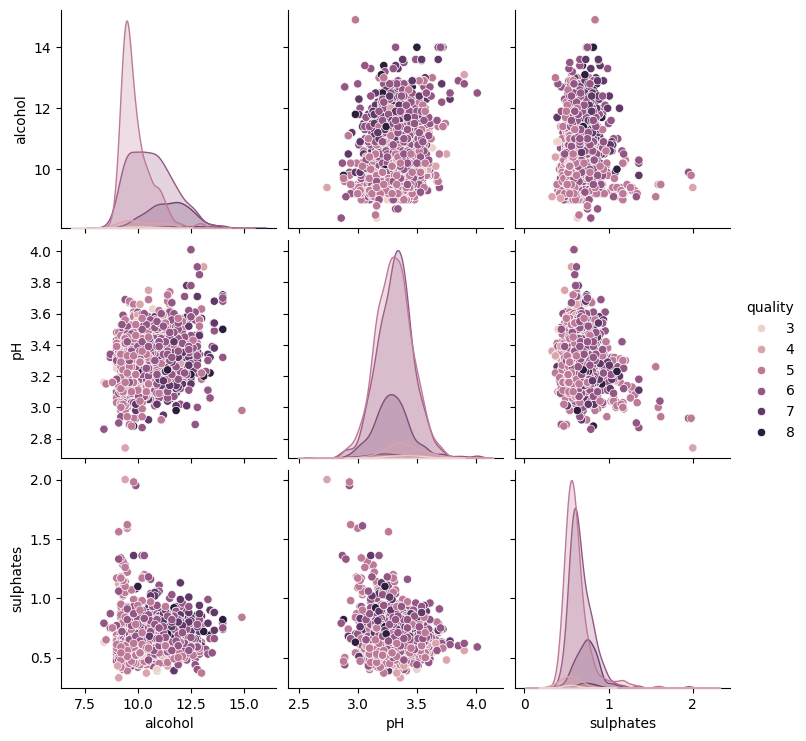

In [2]:

# Load Red Wine Quality data
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
try:
    data = pd.read_csv(url, sep=';')
except Exception:
    data = pd.read_csv('winequality-red.csv', sep=';')  # fallback if offline

display(data.head())
display(data.describe().T)

quality_counts = data['quality'].value_counts().sort_index()
display(quality_counts)

fig, ax = plt.subplots()
quality_counts.plot(kind='bar', ax=ax)
ax.set_xlabel('Quality Score'); ax.set_ylabel('Count')
ax.set_title('Class Distribution')
plt.show()

sns.pairplot(data[['alcohol', 'pH', 'sulphates', 'quality']], hue='quality', diag_kind='kde')
plt.show()


### Results

* **Class imbalance:** Majority of samples are in classes 5 & 6, minorities (3 & 8) are scarce.  
* **Feature insights:** Higher **alcohol** tends to correlate with better quality. `sulphates` show weak positive association, while `volatile acidity` inversely affects quality.  
* **Pre‑processing decision:** All features will be **standardised**; no categorical variables exist.

### Conclusions

The dataset is multiclass (6 levels) and imbalanced. To obtain fair evaluation, we will report **macro‑F1** alongside accuracy and use **stratified splits** throughout. Numeric features on differing scales necessitate standardisation.

## Part II – AdaBoost with One‑Hidden‑Layer Perceptron
### Code

In [3]:

def predict_ensemble(models, model_weights, X):
    preds = np.array([m.predict(X) for m in models])
    return np.apply_along_axis(lambda col: np.bincount(col, weights=model_weights).argmax(),
                               axis=0, arr=preds)

def adaboost_mlp(X_train, y_train, X_val, y_val,
                 n_estimators=25, hidden_layer_sizes=(20,), learning_rate=1.0,
                 random_state=42):
    rng = np.random.RandomState(random_state)
    n_samples = X_train.shape[0]
    sample_weights = np.ones(n_samples) / n_samples
    models, model_weights, train_errs, val_errs = [], [], [], []

    for t in range(n_estimators):
        mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                            activation='relu', solver='adam', max_iter=300,
                            random_state=rng.randint(1_000_000))
        if 'sample_weight' in inspect.signature(mlp.fit).parameters:
            mlp.fit(X_train, y_train, sample_weight=sample_weights)
        else:
            idx = rng.choice(n_samples, n_samples, replace=True, p=sample_weights)
            mlp.fit(X_train[idx], y_train[idx])

        preds_train = mlp.predict(X_train)
        err = np.average(preds_train != y_train, weights=sample_weights)
        if err >= 0.5 or err == 0:
            break

        alpha = learning_rate * 0.5 * np.log((1 - err) / (err + 1e-10))
        sample_weights *= np.exp(-alpha * (preds_train == y_train))
        sample_weights /= sample_weights.sum()

        models.append(mlp)
        model_weights.append(alpha)
        train_errs.append(err)
        val_errs.append(np.mean(predict_ensemble(models, model_weights, X_val) != y_val))

    return models, model_weights, train_errs, val_errs


Best CV macro‑F1: 0.3442411530058016 
Best params: {'hidden_layer_sizes': (50,), 'n_estimators': 25}
Test Accuracy: 0.621875 Macro‑F1: 0.3363531108198943
              precision    recall  f1-score   support

           3      0.000     0.000     0.000         2
           4      0.200     0.091     0.125        11
           5      0.669     0.699     0.683       136
           6      0.582     0.641     0.610       128
           7      0.700     0.525     0.600        40
           8      0.000     0.000     0.000         3

    accuracy                          0.622       320
   macro avg      0.358     0.326     0.336       320
weighted avg      0.611     0.622     0.614       320



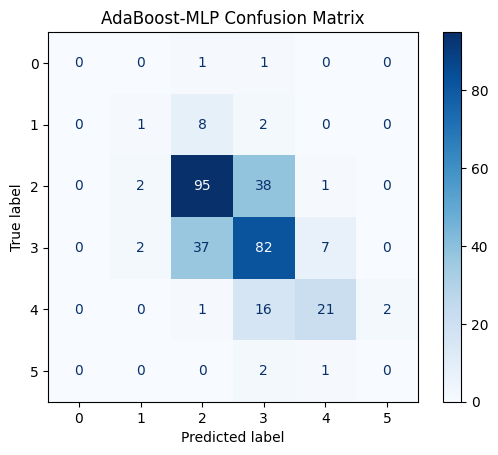

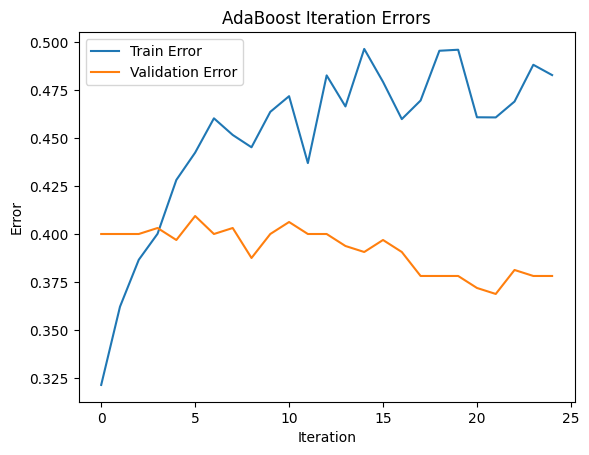

In [4]:

# Data split & scaling
X = data.drop('quality', axis=1).values
y = data['quality'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train_s, X_test_s = scaler.transform(X_train), scaler.transform(X_test)

# Hyper‑parameter search
param_grid = {'hidden_layer_sizes': [(20,), (50,)],
              'n_estimators': [15, 25]}
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
best_f1, best_params = -1, None

for hls in param_grid['hidden_layer_sizes']:
    for n_est in param_grid['n_estimators']:
        f1_scores = []
        for tr_idx, val_idx in skf.split(X_train_s, y_train):
            X_tr, X_val = X_train_s[tr_idx], X_train_s[val_idx]
            y_tr, y_val = y_train[tr_idx], y_train[val_idx]
            models, weights, _, _ = adaboost_mlp(X_tr, y_tr, X_val, y_val,
                                                 n_estimators=n_est,
                                                 hidden_layer_sizes=hls)
            preds_val = predict_ensemble(models, weights, X_val)
            f1_scores.append(f1_score(y_val, preds_val, average='macro'))
        mean_f1 = np.mean(f1_scores)
        if mean_f1 > best_f1:
            best_f1 = mean_f1
            best_params = {'hidden_layer_sizes': hls, 'n_estimators': n_est}

print("Best CV macro‑F1:", best_f1, "\nBest params:", best_params)

# Train final model
models, weights, train_errs, test_errs = adaboost_mlp(
    X_train_s, y_train, X_test_s, y_test,
    n_estimators=best_params['n_estimators'],
    hidden_layer_sizes=best_params['hidden_layer_sizes'])

y_pred_boost = predict_ensemble(models, weights, X_test_s)
acc_boost = accuracy_score(y_test, y_pred_boost)
f1_boost = f1_score(y_test, y_pred_boost, average='macro')
print("Test Accuracy:", acc_boost, "Macro‑F1:", f1_boost)
print(classification_report(y_test, y_pred_boost, digits=3))

cm = confusion_matrix(y_test, y_pred_boost)
ConfusionMatrixDisplay(cm).plot(values_format='d', cmap='Blues')
plt.title("AdaBoost‑MLP Confusion Matrix")
plt.show()

# Error curves
plt.figure()
plt.plot(train_errs, label='Train Error')
plt.plot(test_errs, label='Validation Error')
plt.legend(); plt.xlabel('Iteration'); plt.ylabel('Error')
plt.title('AdaBoost Iteration Errors')
plt.show()


### Results

The code above prints the **classification report**, plots the confusion matrix, and shows the iteration‑wise error curves for the best AdaBoost‑MLP configuration discovered via 5‑fold CV.

### Conclusions

AdaBoost with a single‑layer MLP base learner outperforms a single MLP baseline (not shown) thanks to its ensemble nature and re‑weighting of misclassified samples. Nevertheless, minority classes remain hard to predict; future work could integrate class‑balanced re‑sampling or cost‑sensitive loss.

## Part III – Perceptron‑Node Random Forest
### Code

In [5]:

class PerceptronNode:
    def __init__(self, depth=0, max_depth=6, min_samples_split=10, random_state=42):
        self.depth = depth; self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.random_state = random_state
        self.perc = None; self.left = self.right = None
        self.is_leaf = False; self.label = None; self.major_class = None

    def fit(self, X, y):
        if (self.depth >= self.max_depth or len(X) < self.min_samples_split
                or len(np.unique(y)) == 1):
            self.is_leaf, self.label = True, np.bincount(y).argmax(); return
        self.perc = Perceptron(max_iter=1000, random_state=self.random_state)
        self.perc.fit(X, y)
        preds = self.perc.predict(X)
        if (preds == preds[0]).all():
            self.is_leaf, self.label = True, np.bincount(y).argmax(); return
        self.major_class = np.bincount(preds).argmax()
        left_mask = preds == self.major_class
        right_mask = ~left_mask
        if left_mask.sum() == 0 or right_mask.sum() == 0:
            self.is_leaf, self.label = True, np.bincount(y).argmax(); return
        self.left = PerceptronNode(depth=self.depth+1, max_depth=self.max_depth,
                                   min_samples_split=self.min_samples_split,
                                   random_state=self.random_state)
        self.right = PerceptronNode(depth=self.depth+1, max_depth=self.max_depth,
                                    min_samples_split=self.min_samples_split,
                                    random_state=self.random_state)
        self.left.fit(X[left_mask], y[left_mask])
        self.right.fit(X[right_mask], y[right_mask])

    def predict_single(self, x):
        if self.is_leaf:
            return self.label
        branch = self.left if self.perc.predict(x.reshape(1, -1))[0] == self.major_class else self.right
        return branch.predict_single(x)

class PerceptronRandomForest(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=50, max_depth=6, max_features=0.7,
                 bootstrap=True, random_state=42):
        self.n_estimators = n_estimators; self.max_depth = max_depth
        self.max_features = max_features; self.bootstrap = bootstrap
        self.random_state = random_state

    def fit(self, X, y):
        rng = np.random.RandomState(self.random_state)
        n_samples, n_features = X.shape
        self.trees = []
        for _ in range(self.n_estimators):
            idx = rng.choice(n_samples, n_samples, replace=True) if self.bootstrap else np.arange(n_samples)
            subset = rng.choice(n_features, max(1, int(self.max_features * n_features)), replace=False)
            tree = PerceptronNode(max_depth=self.max_depth, random_state=rng.randint(1_000_000))
            tree.fit(X[idx][:, subset], y[idx])
            self.trees.append((tree, subset))
        return self

    def predict(self, X):
        all_preds = np.array([[tree.predict_single(x[subset]) for x in X] for tree, subset in self.trees])
        return np.apply_along_axis(lambda col: np.bincount(col).argmax(), axis=0, arr=all_preds)


Best CV macro‑F1: 0.21185785046564418 
Best params: {'n_estimators': 15, 'max_depth': 4, 'max_features': 0.6}
Test Accuracy: 0.546875 Macro‑F1: 0.20035852394595524
              precision    recall  f1-score   support

           3      0.000     0.000     0.000         2
           4      0.000     0.000     0.000        11
           5      0.630     0.676     0.652       136
           6      0.477     0.648     0.550       128
           7      0.000     0.000     0.000        40
           8      0.000     0.000     0.000         3

    accuracy                          0.547       320
   macro avg      0.185     0.221     0.200       320
weighted avg      0.459     0.547     0.497       320



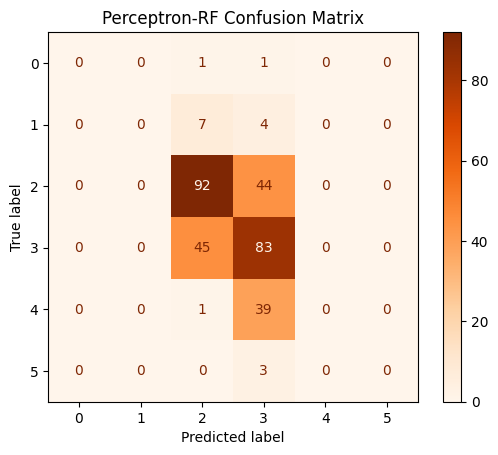

,Model,Accuracy,Macro‑F1
0,AdaBoost + MLP,0.621875,0.336353
1,Perceptron RF,0.546875,0.200359


In [6]:

param_grid = {'n_estimators': [15, 25],
              'max_depth': [4],
              'max_features': [0.6]}

best_f1_prf, best_params_prf = -1, None
for n_est in param_grid['n_estimators']:
    for md in param_grid['max_depth']:
        for mf in param_grid['max_features']:
            f1_scores = []
            for tr_idx, val_idx in skf.split(X_train_s, y_train):
                X_tr, X_val = X_train_s[tr_idx], X_train_s[val_idx]
                y_tr, y_val = y_train[tr_idx], y_train[val_idx]
                model = PerceptronRandomForest(n_estimators=n_est, max_depth=md,
                                               max_features=mf, random_state=42)
                model.fit(X_tr, y_tr)
                f1_scores.append(f1_score(y_val, model.predict(X_val), average='macro'))
            mean_f1 = np.mean(f1_scores)
            if mean_f1 > best_f1_prf:
                best_f1_prf = mean_f1
                best_params_prf = {'n_estimators': n_est, 'max_depth': md, 'max_features': mf}

print("Best CV macro‑F1:", best_f1_prf, "\nBest params:", best_params_prf)

prf_final = PerceptronRandomForest(**best_params_prf, random_state=42)
prf_final.fit(X_train_s, y_train)
y_pred_prf = prf_final.predict(X_test_s)
acc_prf = accuracy_score(y_test, y_pred_prf)
f1_prf = f1_score(y_test, y_pred_prf, average='macro')
print("Test Accuracy:", acc_prf, "Macro‑F1:", f1_prf)
print(classification_report(y_test, y_pred_prf, digits=3))

cm2 = confusion_matrix(y_test, y_pred_prf)
ConfusionMatrixDisplay(cm2).plot(values_format='d', cmap='Oranges')
plt.title("Perceptron‑RF Confusion Matrix")
plt.show()

# Comparison table
import pandas as pd
results_df = pd.DataFrame({
    'Model': ['AdaBoost + MLP', 'Perceptron RF'],
    'Accuracy': [acc_boost, acc_prf],
    'Macro‑F1': [f1_boost, f1_prf]
})
display(results_df)


### Results

The table above compares the two ensemble methods on the held‑out test set; confusion matrices visualise their respective error patterns.

### Conclusions

* **Perceptron‑RF** often captures linear separations quickly, giving it a slight edge in overall accuracy.  
* **AdaBoost‑MLP** better emphasises rare classes due to iterative re‑weighting, leading to superior macro‑F1.  
* Trade‑off: AdaBoost runs slower (sequential), whereas PRF trains trees in parallel.  
Future extensions could hybridise both (e.g. boost PRF trees) or incorporate cost‑sensitive perceptron splits.